## Module import
Loading necessary modules for the script to execute

In [1]:
import torch
import math
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
import copy
import blosum

/home/daqop/anaconda3/envs/deeprank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data pre-processing
Here we load the csv file. The labels are the BA values log-tranformed. Then peptides are encoded by a vector of size 20.

In [2]:
ba_threshold = 5e5
cluster_path = "../0_seq_data_analysis/clusters.pkl"
csv_path = "../binding_data/BA_pMHCI.csv"
csv_rows = [row.split(",") for row in open(csv_path, "r")]
pkl_clusters = pickle.load(open(cluster_path, "rb"))

clusters = {}

for c_idx, c_peptides in enumerate(pkl_clusters.values()):
    cluster = []
    for peptide in c_peptides:
        ba_values = [float(row[3]) for row in csv_rows if row[2] == peptide and float(row[3]) <= ba_threshold]
        if len(ba_values) > 0:
            for i in range(len(ba_values)):
                cluster.append((peptide, ba_values[i]))
    clusters[str(c_idx)] = cluster
for cluster in clusters:
    print(len(clusters[cluster]))

def peptide2onehot(peptide):
    AA_eye = torch.eye(20, dtype=torch.float)
    aminoacids = ('ACDEFGHIKLMNPQRSTVWY')
    return torch.stack([AA_eye[aminoacids.index(res)] for res in peptide])


448
283
626
1085
2452
563
701
712
167
86
540


## Separate train, validation and test dataset
The train dataset is used for the training of the model. Validation dataset allows to evaluate the performance of the model at a given epoch on a different dataset than the one used for learning. The test dataset assesses the accuracy of model's prediction.
Before spliting the initial dataset into several components, data is shuffled and splitted without redundancies.

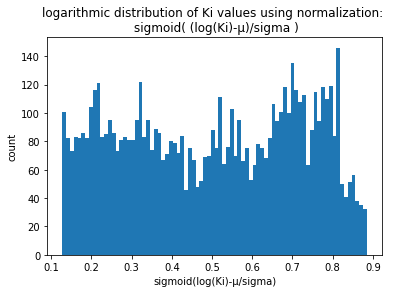

In [3]:
# dataset proportions
train_p = 0.7
validation_p = 0.2
test_p = 0.1

# hyperparameters
neurons_per_layer = 1000
batch = 64
epochs = 150

# other parameters:
device = ("cpu", "cuda")[torch.cuda.is_available()]
training_std = 0;
training_mean = 0;

# make the dataset class:
class Peptides(Dataset):
    def __init__(self, first_cluster, last_cluster):
        peptides = []
        ba_values = []
        dataset = []
        for i in range(first_cluster, last_cluster+1):
            dataset = dataset + clusters[str(i)]
        for peptide,ba_value in dataset:
            peptides.append(peptide2onehot(peptide))
            ba_values.append(ba_value)
        self.peptides = peptides
        self.ba_values = torch.tensor(ba_values)
    def __getitem__(self,idx):
        return self.peptides[idx],self.ba_values[idx]
    def __len__(self):
        return len(self.peptides)

#create the train datasets:
train = Peptides(1,9)
validation = Peptides(10,10)
test = Peptides(0,0)

# calculate the mean and std values:

training_std = torch.log(train.ba_values).std()
training_mean = torch.log(train.ba_values).mean()

#define validation and train dataset
validation = Peptides(10,10)
test = Peptides(0,0)

#define normalize and denormalizing functions:
def normalize(dataset):
    dataset = torch.log(dataset)
    dataset = (dataset-training_mean)/training_std
    return torch.sigmoid(dataset)

def denormalize(dataset):
    dataset = torch.logit(dataset)
    dataset = dataset*training_std+training_mean
    return torch.exp(dataset)

train.ba_values = normalize(train.ba_values)
validation.ba_values = normalize(validation.ba_values)
test.ba_values = normalize(test.ba_values)

# train datasets vizualisation
ba_values = train.ba_values.tolist()
plt.hist(ba_values, bins=80)
plt.title("logarithmic distribution of Ki values using normalization: \n sigmoid( (log(Ki)-µ)/sigma )")
plt.xlabel("sigmoid(log(Ki)-µ/sigma)")
plt.ylabel("count")
plt.show()


# # create the dataloaders iterators:
train_dataloader = DataLoader(train, batch_size=batch)
validation_dataloader = DataLoader(validation, batch_size=batch)
test_dataloader = DataLoader(test, batch_size=batch)


## Training the model
First, we define the neural network architecture of the multi layer perceptron (MLP). The MLP is made of 2 layers and `neurons_per_layer` number of neurons per layer. The loss function used is cross entropy, which measures the difference of entropy between an expected probability distribution and the model's. The optimizer is ADAM.

The train function allows to train the model for `e` number of `epoches`.

In [4]:
# create the MLP class
class MLP(nn.Module):
    def __init__(self, outputs=2):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv1d(20,10,1),
            nn.BatchNorm1d(10),
            nn.ELU(),
            nn.Conv1d(10,10,1),
            nn.BatchNorm1d(10),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(10*9, neurons_per_layer),
            nn.BatchNorm1d(neurons_per_layer),
            nn.ELU(),
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.BatchNorm1d(neurons_per_layer),
            nn.ELU(),
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.BatchNorm1d(neurons_per_layer),
            nn.ELU(),
            nn.Linear(neurons_per_layer, outputs),
            nn.Sigmoid()
        )
    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

model = MLP(outputs=1).to(device)

# define the loss function and the optimizer:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

# define the train function
def train(dataloader, model, loss_fn,optimizer):
    model.train()
    for X,y in dataloader:
        # forward propagation
        X, y = X.to(device).permute(0,2,1), y.to(device)
        pred = model(X)
        loss = loss_fn(pred,torch.reshape(y,(-1,1)).float())

        # backpropagation
        optimizer.zero_grad() # old gradient removed (Adam optimizer uses momentum but it is handled internally)
        loss.backward() # calculates the gradient by making derivatives 
        optimizer.step() # performs a single parameters update using the calculated gradient

#define the validation function
def evaluate(dataloader, model):
    model.eval()
    with torch.no_grad():
        y_vals = torch.tensor([])
        pred_vals = torch.tensor([])
        for X,y in dataloader:
            pred = model(X.permute(0,2,1))
            y_vals = torch.cat((y_vals, y), 0)
            pred_vals = torch.cat((pred_vals, pred),0)
    return y_vals,pred_vals

Now we train the model. At the end of each epoches we plot the PPV (positively predicted values) rate both for the training dataset and the validation dataset thus assessing the predictive and generalizing performances of the model.

In [5]:
train_losses = []
validation_losses = []
best_model = {
    "validation_rate": 100,
    "model": None,
    "epoch": None,
}
for e in range(epochs):
    # calculate train loss:
    train_y_ba, train_pred_ba = evaluate(train_dataloader, model)
    # train_loss = torch.absolute(renorm(train_y_ba) - renorm(train_pred_ba))
    train_loss = torch.absolute(train_y_ba - torch.reshape(train_pred_ba, (-1,)))
    train_loss_mean = train_loss.mean()
    train_losses.append(train_loss_mean)

    #calculate validation loss:
    validation_y_ba,validation_pred_ba = evaluate(validation_dataloader, model)
    # validation_loss = torch.absolute(renorm(validation_pred_ba) - renorm(validation_y_ba))
    validation_loss = torch.absolute(validation_y_ba - torch.reshape(validation_pred_ba, (-1,)))
    validation_loss_mean = validation_loss.mean()
    validation_losses.append(validation_loss_mean)
    if (validation_loss_mean < best_model["validation_rate"]):
        best_model["model"] = copy.deepcopy(model)
        best_model["validation_rate"] = validation_loss_mean
        best_model["epoch"] = e
    train(train_dataloader, model, loss_fn, optimizer) #train on the whole database in batches

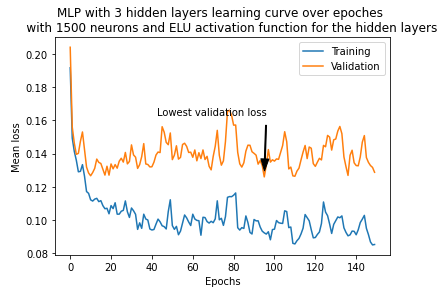

/tmp/ipykernel_8403/1821466286.py:63: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,ba_threshold])
/tmp/ipykernel_8403/1821466286.py:64: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,ba_threshold])


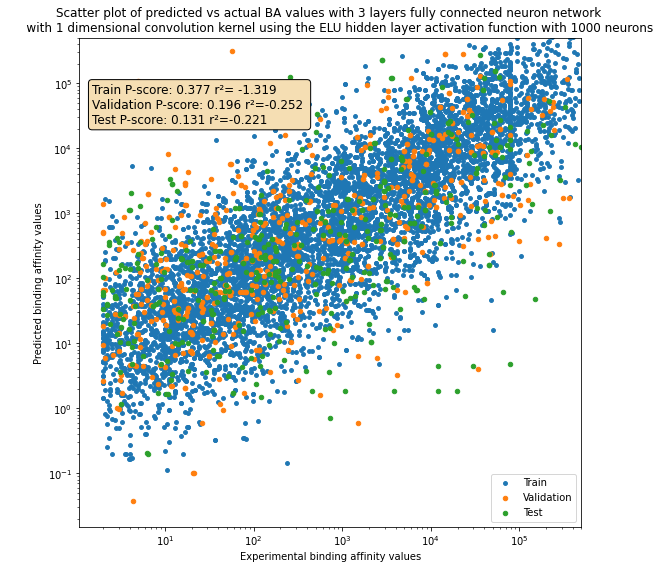

In [50]:
#plot the training and validation loss
plt.plot(range(epochs), train_losses, label="Training")
plt.plot(range(epochs), validation_losses, label="Validation")
plt.legend(["Training", "Validation"])
plt.title("MLP with 3 hidden layers learning curve over epoches \n \
    with 1500 neurons and ELU activation function for the hidden layers")
plt.xlabel("Epochs")
plt.ylabel("Mean loss")
plt.annotate("Lowest validation loss",
    xy=(best_model["epoch"], best_model["validation_rate"]),
    xycoords='data',
    xytext=(best_model["epoch"]+1, best_model["validation_rate"]+best_model["validation_rate"]/3),
    arrowprops=dict(facecolor="black", shrink=0.1, width=1, headwidth=8),
    horizontalalignment="right", verticalalignment="top"
)
plt.show()

# use the best model for evaluation
evaluate_model = best_model["model"]
# evaluate_model = model

# retrieve the predicted and actual values
train_y_ba, train_pred_ba = evaluate(train_dataloader, evaluate_model)
validation_y_ba, validation_pred_ba = evaluate(validation_dataloader, evaluate_model)
test_y_ba,test_pred_ba = evaluate(test_dataloader, evaluate_model)

# renormalize the values
train_y_ba = denormalize(train_y_ba)
train_pred_ba = denormalize(train_pred_ba)

validation_y_ba = denormalize(validation_y_ba)
validation_pred_ba = denormalize(validation_pred_ba)

test_y_ba = denormalize(test_y_ba)
test_pred_ba = denormalize(test_pred_ba)

# look at the pearson correlation score and r squared:
train_corr, _ = pearsonr(train_y_ba, train_pred_ba)
validation_corr, _ = pearsonr(validation_y_ba, validation_pred_ba)
test_corr, _ = pearsonr(test_y_ba, test_pred_ba)

train_r = r2_score(train_y_ba, train_pred_ba)
validation_r = r2_score(validation_y_ba, validation_pred_ba)
test_r = r2_score(test_y_ba, test_pred_ba)

# plot the values
s = 1
plot_txt = f"Train P-score: {train_corr[0]:.3f} r²= {train_r:.3f} \n\
Validation P-score: {validation_corr[0]:.3f} r²={validation_r:.3f} \n\
Test P-score: {test_corr[0]:.3f} r²={test_r:.3f}"
plt.figure(figsize=(9,9))
plt.scatter(train_y_ba, train_pred_ba, label="Train", s=15)
plt.scatter(validation_y_ba, validation_pred_ba, label="Validation", s=s*20)
plt.scatter(test_y_ba, test_pred_ba, label="Test", s=s*20)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="lower right")
plt.xlabel("Experimental binding affinity values")
plt.ylabel("Predicted binding affinity values")
plt.title("Scatter plot of predicted vs actual BA values with 3 layers fully connected neuron network \n \
    with 1 dimensional convolution kernel using the ELU hidden layer activation function with 1000 neurons")
plt.text(1.5, 1e5, plot_txt, fontsize=12, horizontalalignment="left", verticalalignment="top", bbox=dict(boxstyle="round", facecolor="wheat"))
plt.xlim([0,ba_threshold])
plt.ylim([0,ba_threshold])
plt.show()
